This notebook deals with Principal Component Analysis (PCA), which is a method for finding a new (and hopefully more efficient) representation of continuously valued features.  PCA is used for two primary tasks.  The first is the analysis of combinations of independent variables in an effort to describe the patterns underlying features in a more concise way.  The second and more ubiquitous use is for dimensionality reduction: throwing away data that is redundant or non-explanatory.  Let's look at an example for what we mean by this.

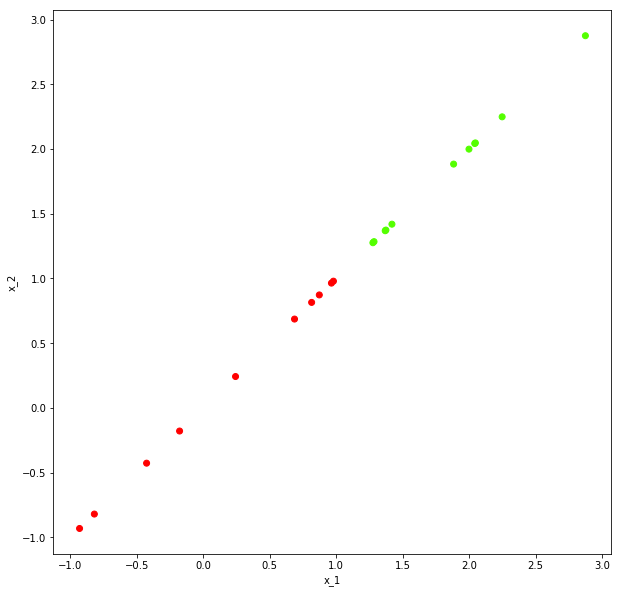

In [3]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)

# Let's generate a synthetic dataset, with two features, and one label
x_1 = np.random.randn(21) + 1.0
x_2 = x_1.copy()
X = np.column_stack((x_1,x_2))
y = (x_1>1) + (x_2>1)

plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.prism)
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.show()

Ignoring the class labels for a moment, what is the dimensionality of the above dataset?  Ostensibly, it is two dimensional because the data varies in both $x_1$ and $x_2$.  However, what would happen if we simply rotated the coordinate system by 45 degrees (either clockwise or counter-clockwise)?  This rotation matrix is given by 
$$
R = \begin{bmatrix} \cos \theta & -\sin \theta \\
                               \sin \theta & \cos\theta \end{bmatrix}
                              $$
If we multiply our data matrix $X$ by this matrix, we get the following new data matrix $X_{new}$

In [ ]:
theta = np.deg2rad(-45)
R = np.array([[np.cos(theta),-np.sin(theta)],
              [np.sin(theta),np.cos(theta)]])

X_new = np.dot(X,R.T)
print(X_new)

plt.scatter(X_new[:,0],X_new[:,1],c=y,cmap=plt.cm.prism)
plt.xlabel('x\'_1')
plt.ylabel('x\'_2')
plt.show()


Thus, for the right choice of coordinates, this dataset becomes one dimensional.  What was the right choice of coordinates?  In this case, our new axes (expressed in terms of the original ones) were 
$$
x'_1 = a x_1 + b x_2
$$
$$
x'2 =  c x_2 - d x_1,
$$
with $a,b,c,d=\frac{1}{\sqrt{2}}$.  These new axes are called *basis* vectors.  What can we say about them?  First, they are a linear combination of the original coordinate system's basis vectors.  Second, they are orthogonal to one another (as is the original coordinate system): $x'1^T x'2 = 0$.  Finally, they are normalized: $x'1^T x'1 = 1$.  

In fact, these properties would have held regardless of our choice of $\theta$.  We just happend to select $\theta$ such that it got rid of all the information on one of the dimensions.  Why is this useful?  Imagine we wanted to perform classification on this dataset.  A good classifier in the original coordinates would be:
$$
y_{pred} = \begin{cases} 1\;\mathrm{if}\;x_1<1,x_2<1 \\
                  0\;\mathrm{else} \end{cases}
$$
In the new coordinate system, a good classifier is 
$$
y_{pred} = \begin{cases} 1\;\mathrm{if}\;x'_1<\frac{1}{\sqrt{2}} \\
                  0\;\mathrm{else} \end{cases}
$$
Note that the classifier doesn't depend on $x'2$, and we have to do have as many operations: with some preprocessing, we have made our model more efficient by a factor of 2, and reduced the number of parameters by the same.  

Can we do this for an arbitrary dataset though?  Consider a similar dataset but with noise added in both $x_1$ and $x_2$

In [ ]:
# Let's generate a synthetic dataset, with two features, and one label
x_1 = np.random.randn(21) + 1.0
x_2 = x_1.copy()
X = np.column_stack((x_1,x_2))
X += np.random.randn(*X.shape)*0.1
y = (x_1>1) + (x_2>1)

plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.prism)
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.show()

Now what should we do?  There's no longer a clear rotation that reduces the dimensionality of the problem.  However, we can see that not all dimensions have the same amount of information.  Can we still come up with a rotation that gives a coordinate system that is better than this one?  First we need a definition for *better*.  

We can take some inspiration from the previous (much easier) dataset.  In that case, we came up with the rotation that allowed us to explain *all* the variability in the data with a single axis.  Clearly we won't be able to do that in this case, but perhaps we can come up with the rotation that allows us to explain as much variability in the data *as possible* with a single axis.  But how can we quantify variability?  Here, we can retreat to a familiar assumption, namely that the data is distributed according to a multivariate normal (MVN).  If we do that, then it's quite simple to quantify the variability in the data through the sample covariance $\Sigma$.  Let's compute that for this dataset.

In [ ]:
Xbar = X.mean(axis=0)   # Compute the sample mean
Sigma = 1./(len(X)-1)*np.dot((X-Xbar).T,(X-Xbar))
print (Sigma)

What does this distribution look like?  

In [ ]:
import sys
sys.path.insert(0,'./libraries/')
from plot_ellipse import plot_ellipse

plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.prism)
plot_ellipse(Xbar,Sigma,alpha=0.3)
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.show()

Given this information, it's relatively obvious what the rotation that we come up with should be: the major axis of this ellipse.  Stated alternatively, what's the rotation that makes the covariance matrix diagonal?  To rotate a matrix, we have to rotate both the rows and the columns, and so we need a matrix $R$, that does this:
$$
R^T \Sigma R = \Lambda,
$$
where $\Lambda$ is a diagonal matrix with the variance along the ellipse axes on the diagonals.  As it turns out, this is called the eigen-decomposition of a matrix (remember eigenvalues and vectors from linear algebra?).  Thus we can find the rotation matrix $R$ by finding the eigenvectors of the covariance matrix.  Even better, we can compute the variance associated with each one of the resulting axes by finding the eigenvalues.  

In [ ]:
lamda,R = np.linalg.eig(Sigma)  # Find the eigenvalues and vectors of the covariance matrix
idx = lamda.argsort()[::-1]     # Sort them, largest to smallest
lamda = lamda[idx]
R = R[:,idx]

X_new = np.dot(X-Xbar,R)

In [ ]:
print(X_new)

In [ ]:
plt.scatter(X_new[:,0],X_new[:,1],c=y,cmap=plt.cm.prism)
plot_ellipse(np.zeros((2)),np.diag(lamda),alpha=0.3)
plt.xlabel('x\'_1')
plt.ylabel('x\'_2')
plt.axis('equal')
plt.show()

Now the covariance matrix is diagonal, and most of the variability is on the $x'_1$ axis.  In fact, so much of the variability is explained by $x'_1$, that maybe we don't even need to keep $x'_2$.  We can determine precisely how much of the variability in the data is explained by each axis by normalizing the eigenvalues.

In [ ]:
variance_fraction = lamda/lamda.sum()
print(variance_fraction)

More than 99\% of the variance is explained by the first principal component!  Thus we could ignore that second dimension and still make a good classifier.  What are we doing by ignoring that second component?

In [ ]:
X_new[:,1] = 0  # Set the information associated with the second PCA to zero
X_simplified = np.dot(X_new,R.T) + Xbar
plt.scatter(X_simplified[:,0],X_simplified[:,1],c=y,cmap=plt.cm.prism)
plt.scatter(X[:,0],X[:,1],marker='^')
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.show()

All the points now fall on a line in the original coordinate system.  This is sort of like linear regression, but with an important distinction: in linear regression the thing that was being minimized was the vertical difference between the line and the dependent variable.  In this case, we're drawing the line that minimizes the distance *perpendicular* (or orthogonal) to the line.  This is the result of the fact that this algorithm is unsupervised: no variable is any more special than any other in this case.  However, this does help us to come up with a second interpretation of the first principal component: it is the line that passes closest to the data points.

To review, there are two completely equivalent ways to interpret the first principal component:  1, it is the axis along which the maximum amount of variability in the data falls, and 2) it is the line which minimizes the orthogonal distance between itself and the data points.  

Note that in this case, because we're considering rotations, we didn't have a choice regarding what the second principal component should be, because it was completely specified by the requirement that it be orthogonal to the first.  This can be seen by the fact that there is only one parameter ($\theta$) in a 2D rotation matrix.  This is not the case for higher dimensions.  However, the procedure can be applied recursively: the second principal component is the direction that maximizes the explained variance, excluding the variance explained by the first principal component.  Fortunately, the math doesn't change; we still find the principal components by computing the sample covariance, finding its eigenvectors and eigenvalues, and sorting these from largest to smallest.  The eigenvalues from largest to smallest still represent the amount of variance accounted for in the direction of their associated eigenvector/principal component.  

Let's see how this applies to a familiar dataset.

In [ ]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target
X,X_test,y,y_test = train_test_split(X,y,test_size=0.33)

classes = [0,1,2]

m = X.shape[0]
n = X.shape[1]
N = len(classes)

fig,axs = plt.subplots(nrows=4,ncols=4)
for i in range(4):
    for j in range(4):
        if i>j:
            axs[i,j].scatter(X[:,i],X[:,j],c=y,cmap=plt.cm.prism)
            axs[i,j].set_xlabel(iris['feature_names'][i])
            axs[i,j].set_ylabel(iris['feature_names'][j])
        else: # delete redundant plots
            fig.delaxes(axs[i,j])

plt.show()

The iris dataset is 4D.  Let's use PCA to see how many dimensions it *really* has.  

In [ ]:
Xbar = X.mean(axis=0)   # Compute the sample mean
Sigma = 1./(len(X)-1)*np.dot((X-Xbar).T,(X-Xbar))
print (Sigma)

In [ ]:
lamda,R = np.linalg.eig(Sigma)  # Find the eigenvalues and vectors of the covariance matrix
idx = lamda.argsort()[::-1]     # Sort them, largest to smallest
lamda = lamda[idx]
R = R[:,idx]

X_new = np.dot(X-Xbar,R)
X_new_test = np.dot(X_test-Xbar,R)

As before, we can look at the values of $\lambda$ to determine how much of the information content lies in each PC by normalizing it

In [ ]:
print(lamda/lamda.sum()) #Variance fraction

A more useful metric when deciding what dimensions to keep might be the *cumulative* variance fraction.  As this number approaches one, all of the variability of the data is explained.

In [ ]:
print(np.cumsum(lamda/lamda.sum())) #Cumulative variance fraction

This is pretty interesting.  Less than half a percent of the information content of the dataset is explained by the last component.  This is strong evidence that this dataset is actually close to 3D, rather than 4D.  Realistically, the third PC isn't all that interesting either, explaining less than 2\% of the total data variance.  Let's plot the transformed dataset in the first two dimensions.

In [ ]:
plt.scatter(X_new[:,0],X_new[:,1],c=y,cmap=plt.cm.prism)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

If you stuck a piece of paper through 4D space in a way that it was closest to all the points, then drew a dot on the paper where each point was closest, this is what you would get.  Remember that this has more than 97% of the information content of the original dataset, but with only half the dimensions.  You can easily run a classifier on these transformed observations.  



In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
nb = GaussianNB()


### Confusion matrix for PCA'd iris dataset; two components ###
X_new_2 = X_new[:,:2]
X_new_2_test = X_new_test[:,:2]
nb.fit(X_new_2,y)
y_pred = nb.predict(X_new_2_test)
print("confusion matrix with 2 component PCA")
print(confusion_matrix(y_test,y_pred))

### Confusion marix for PCA'd iris dataset; three components ###
X_new_3 = X_new[:,:3]
X_new_3_test = X_new_test[:,:3]
nb.fit(X_new_3,y)
y_pred = nb.predict(X_new_3_test)
print("confusion matrix with 3 component PCA")
print(confusion_matrix(y_test,y_pred))

### Confusion marix for PCA'd iris dataset; four components ###
nb.fit(X_new,y)
y_pred = nb.predict(X_new_test)
print("confusion matrix with 4 component PCA")
print(confusion_matrix(y_test,y_pred))

### Confusion marix for iris dataset; four components ###
nb.fit(X,y)
y_pred = nb.predict(X_test)
print("confusion matrix with non-transformed data")
print(confusion_matrix(y_test,y_pred))


Note the somewhat interesting behavior here with Naive Bayes, in that we get different classifier accuracies between the four component PCA (just different axes, no information lost) and untransformed naive Bayes: this is a result of the naive assumption: since we're not modelling correlations between the features, a rotated dataset produces a different result.  While it didn't work quite as well in this case, it could have just as easily gone the other way.

Finally, it can be quite interesting to look at the PCs themselves, particularly the important ones, to see which combinations of features are explaining most of the variability.

In [ ]:
print (R[:,0])  # Print the first PC
print (iris.feature_names)

This is like a recipe for explaining variability in the data.  It's saying "if you want to find the direction that spreads the data out the most, add 35% of sepal length, subtract 7% sepal width, add 85% petal length and 37% petal width".  

While these examples are informative, it's difficult to see the power of PCA on low-dimensional datasets like this.  At the same time, it's difficult to understand what the PCs represent in high dimensional datasets (even the iris example).  An exception to this is *image* data, where the spatial correlation of pixels lets us visualize principal components, even in high dimensions.  To see this, let's look at the MNIST dataset, which is a set of handwritten digits that are 28x28 pixels.

In [1]:
from sklearn import datasets

mnist = datasets.fetch_mldata('MNIST original')

Let's plot some random examples of MNIST.

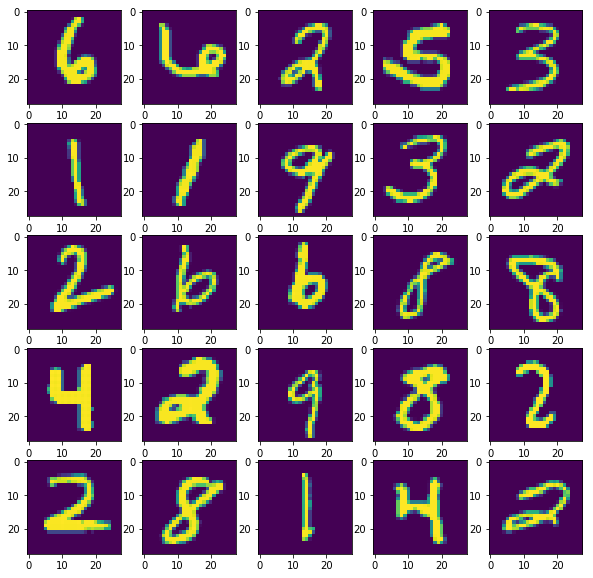

In [4]:
fig,axs = plt.subplots(nrows=5,ncols=5)
for r in axs:
    for ax in r:
        ax.imshow(mnist.data[np.random.randint(len(mnist.data)),:].reshape((28,28)))
plt.show()

Since this is the first time we've really messed with *image* data, it's worth thinking for just a moment about what the features are.

In [5]:
X[0]

array([ 0.68648427,  0.68648427])

This time, we'll use sklearn's fast implementation of the PCA.  To begin, we'll compute the first 50 components of the PCA

In [9]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=50,copy=True)  
pca.fit(mnist.data)
X = pca.transform(mnist.data)

Recall that each PC is just a linear combination of the input features.  Since the input features in this case are pixel values, we can transform the PCs back into 28x28 images, and plot the intensity of each.  This produces something called an eigendigit.  Let's plot the first 9:

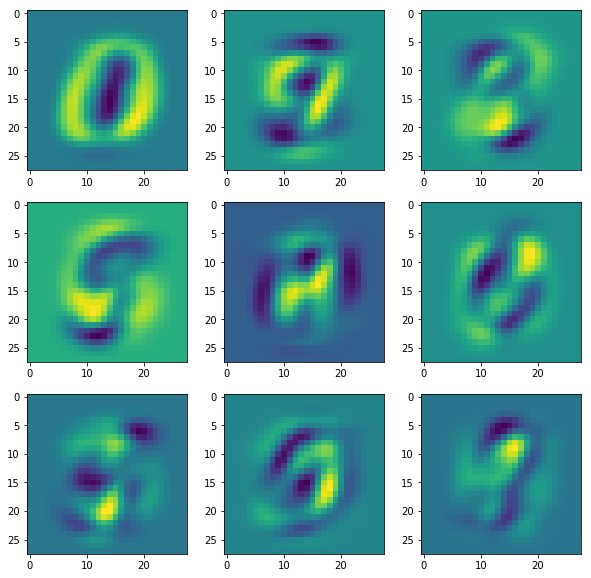

In [10]:
fig,axs = plt.subplots(nrows=3,ncols=3)
counter = 0
for r in axs:
    for ax in r:
        ax.imshow(pca.components_[counter,:].reshape((28,28)))
        counter+=1
plt.show()

These represent the best possible basis for describing digits, which is to say that if you only had image that you had to scale to describe all of the digits in MNIST, that O thing would be the one.  If you could only use linear combinations of two images to describe all of MNIST, it would be the first two.  This seems absurd, but think about what the original basis set is for images:

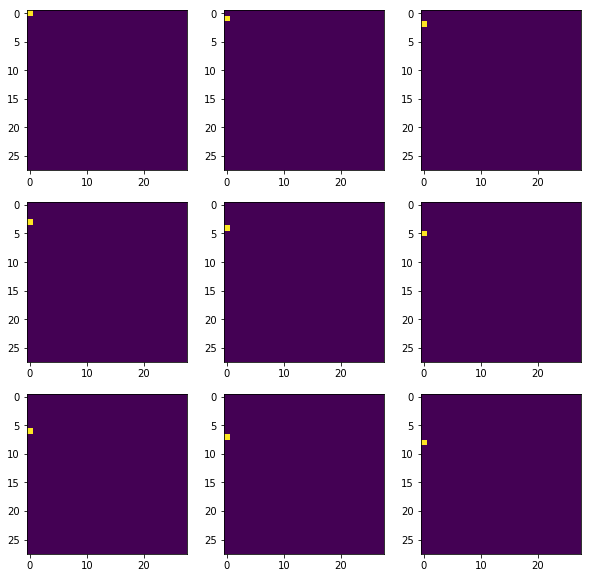

In [11]:
fig,axs = plt.subplots(nrows=3,ncols=3)
counter = 0
for r in axs:
    for ax in r:
        basis = np.zeros((28,28))
        basis[counter,0] = 1
        ax.imshow(basis)
        counter+=1
plt.show()

Clearly, the PCA basis is more informative!  Just how informative? Let's look at the cumulative variance accounted for by the PCA.

In [12]:
print (np.cumsum(pca.explained_variance_ratio_))

[ 0.09746116  0.16901561  0.23051091  0.28454476  0.3334341   0.37648637
  0.40926898  0.4381654   0.46574904  0.48917044  0.51023733  0.53061286
  0.5476835   0.5646237   0.58045752  0.59532097  0.60851456  0.6213047
  0.63317742  0.64470679  0.65536719  0.66546513  0.67505665  0.684153
  0.69298586  0.70137405  0.70947236  0.71732954  0.72473217  0.73163231
  0.73819375  0.74464845  0.75065664  0.75651275  0.76218028  0.76761498
  0.77266212  0.77753286  0.78232233  0.7869982   0.79154186  0.79599095
  0.80017298  0.80413406  0.8079703   0.81172763  0.81533942  0.8188276
  0.82221352  0.82540369]


That first component explains a full 10% of data variability.  The first 50 components explain 82% of the variability.  Note that this data is obviously far more multi-faceted and complex than the iris dataset.  Not only are there more classes (10 digits), but also there is more intra-class variability (the variability between how different people write sixes, for example).  How many PCs do we need in order to get up to 95% variance?  sklearn lets us specify a variance ratio, and it will keep computing PCs until it gets there.

In [15]:
pca = decomposition.PCA(0.95,copy=True,whiten=False)
pca.fit(mnist.data)
X = pca.transform(mnist.data)

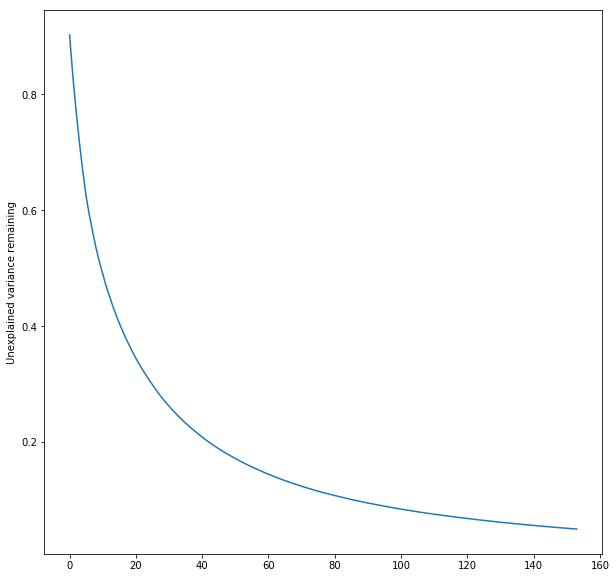

0.19642857142857142

In [16]:
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(1-cumulative_variance_ratio)
plt.ylabel('Unexplained variance remaining')
plt.show()
154/784

This is known as a scree plot (for the shape of a mountainside).  It represents how much information you're throwing away for a given model simplification.  At L=154 PCs, we're throwing away 5% of the data.  But that's a huge compression! We still have 95% of the information at $154/784 \approx 20\%$ of the number of features.

When we transform our data into representation by the PCs, our new data representation is a vector of length 154, which isn't conducive to visualization.  However, we can reconstruct what our data looks like under the basis simplification, just like we did when we zeroed out a column in the synthetic example, then transformed back to the original coordinates.  We do this by taking a linear combination of the PCs, with the coefficients given by the entries in the data matrix.

In [ ]:
fig,axs = plt.subplots(nrows=5,ncols=2)
fig.set_size_inches(12,30)

data_index = 15000
for i,n_components in enumerate([1,5,10,50,150]):
    X_reconstructed = 0
    counter = 0 
    for c,l in zip(pca.components_,X[data_index]):
        if counter<n_components:
            X_reconstructed += c*l
        counter += 1
    X_reconstructed += pca.mean_
    X_reconstructed = X_reconstructed.reshape((28,28))

    axs[i,0].imshow(mnist.data[data_index,:].reshape((28,28)),vmin=0,vmax=255)
    axs[i,1].imshow(X_reconstructed,vmin=0,vmax=255)
    axs[i,1].set_title("L="+str(n_components))
plt.show()

Finally, we can use this method to come up with a fairly efficient classifier for these digits in a very similar way to what we did before.  We can even use Gaussian Naive Bayes.

In [ ]:
from sklearn import datasets

mnist = datasets.fetch_mldata('MNIST original')
X,X_test,y,y_test = train_test_split(mnist.data,mnist.target,test_size=0.33)

pca = decomposition.PCA(35,copy=True,whiten=True)
pca.fit(X)
X_pca = pca.transform(X)
X_pca_test = pca.transform(X_test)

nb = GaussianNB()
### Confusion marix for mnist dataset###
nb.fit(X_pca,y)
y_pred = nb.predict(X_pca_test)
c = confusion_matrix(y_test,y_pred)
accuracy = np.diagonal(c).sum()/c.sum()
print("Confusion matrix: \n",c)
print("Classification accuracy: ",accuracy)



Just out of curiosity, what did this classifier get wrong?

In [ ]:
random_wrong_value = np.random.choice(np.where(y_pred!=y_test)[0])
fig,axs = plt.subplots(nrows=1,ncols=1)
axs.imshow(X_test[random_wrong_value].reshape((28,28)))
print("Classified as :",y_pred[random_wrong_value])
print("Actual class :",y_test[random_wrong_value])
plt.show()


In [ ]:
np.random.choice?
